In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
from ahrs.filters import Mahony

import importlib
importlib.reload(fetch_data)

start_date_str = '2023-05-30'
end_date_str = '2023-06-01'
organization_id = 'hamid'
can_k3y_id = '9ed5b50e'
imu_k3y_id = '78f8031e'

Get the CAN Server data

In [2]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)

Get the raw IMU data

In [21]:
raw_acc_df, raw_gyro_df = fetch_data.get_raw_data(imu_k3y_id, organization_id, start_date_str, end_date_str)
start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')
time_df = correct_drift.fetch_time_data(imu_k3y_id, organization_id, start_date, end_date)

Define Functions for Computing Orientation

In [73]:
k3y_g = 9.81
# SR = 26
SR = 100
S3_K3Y_VEH_ROT_MTX = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
# madgwick_params = {'gain': 0.05, 'imu_gain': 0.0001,
                #    'init_qua': [0,0,0,1]}
madgwick_params = {'gain': 0.02, 'imu_gain': 0.0001,
                   'init_qua': [0,0,0,1]}
butter_params = {'order': 4, 'Wn': 10.0}

def calculate_rot_matrix(ac_data, gy_data, sr=SR, filter_params=madgwick_params):
    # ac_data[:,0] = lowpass_filt(ac_data[:,0], sr=SR, wn=butter_params['Wn'])
    # ac_data[:,1] = lowpass_filt(ac_data[:,1], sr=SR, wn=butter_params['Wn'])
    # ac_data[:,2] = lowpass_filt(ac_data[:,2], sr=SR, wn=butter_params['Wn'])
    # gy_data[:,0] = lowpass_filt(gy_data[:,0], sr=SR, wn=butter_params['Wn'])
    # gy_data[:,1] = lowpass_filt(gy_data[:,1], sr=SR, wn=butter_params['Wn'])
    # gy_data[:,2] = lowpass_filt(gy_data[:,2], sr=SR, wn=butter_params['Wn'])
    madg_filter = Madgwick(acc=ac_data, gyr=gy_data, Dt=(1/sr), gain=filter_params['gain'],
                        q0=filter_params['init_qua'], gain_imu=filter_params['imu_gain'])
    # madg_filter = Mahony(acc=ac_data, gyr=gy_data, Dt=(1/sr),
    #                     q0=filter_params['init_qua'], k_P=0.001)
    quaternions = madg_filter.Q
    madgwick_params['init_qua'] = quaternions[-1,:]
    # converting quaternion from scalar first (AHRS library) to scalar last(SciPy)
    quaternions_scipy = np.roll(quaternions, shift=3, axis=1)
    rot_mtxs = R.from_quat(quaternions_scipy).as_matrix()

    return rot_mtxs

def gravity_compensate(ac_batch, gy_batch, g=k3y_g):
    rotation_mtxs = calculate_rot_matrix(ac_data=ac_batch, gy_data=gy_batch)
    # Rotation matrix is orthogonal, last colum = last row of the inverse
    gravity_components = g * rotation_mtxs[:,-1,:]
    ac_g_compensated = ac_batch - gravity_components

    return ac_g_compensated

def imu_k3y_to_vehicle(ac_batch_np, gy_batch_np):
    g_removed_ac_np = gravity_compensate(ac_batch=ac_batch_np[:, 1:], gy_batch=gy_batch_np[:, 1:], g=k3y_g)
    vehicle_ac = np.matmul(S3_K3Y_VEH_ROT_MTX, g_removed_ac_np.T)
    vehicle_ac_np = np.column_stack((ac_batch_np[:,0], vehicle_ac.T))

    return vehicle_ac_np

def lowpass_filt(data, sr=SR, wn=butter_params['Wn'],
                order=butter_params['order']):
    b, a = signal.butter(N=order, Wn=wn, analog=False, fs=sr)
    filt_data = signal.filtfilt(b, a, data)
    return filt_data

Filter the Data for Only Driving States

In [ ]:
raw_acc_df = correct_drift.shift_time(raw_acc_df, time_df)
raw_gyro_df = correct_drift.shift_time(raw_gyro_df, time_df)

buffer = 5
ac_dr_df_list = []
gy_dr_df_list = []
for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    # get just the data within the driving state
    ac_dr_motion = raw_acc_df[(raw_acc_df['correct_timestamp'] >= dr_start_time + buffer) 
                        & (raw_acc_df['correct_timestamp'] <= dr_end_time)]
    gy_dr_motion = raw_gyro_df[(raw_gyro_df['correct_timestamp'] >= dr_start_time + buffer) 
                        & (raw_gyro_df['correct_timestamp'] <= dr_end_time)]
    
    # gravity compensate batch
    merged_data = pd.merge(ac_dr_motion, gy_dr_motion)
    

In [74]:
cutoff_time = 1685550631.3832176
raw_acc_df = raw_acc_df[raw_acc_df['timestamp(epoch in sec)'] < cutoff_time]
raw_gyro_df = raw_gyro_df[raw_gyro_df['timestamp(epoch in sec)'] < cutoff_time]

merged_data = pd.merge(raw_acc_df, raw_gyro_df, on='timestamp(epoch in sec)', how='inner')
raw_acc_np = merged_data[['timestamp(epoch in sec)', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
raw_gyro_np = raw_gyro_df.to_numpy()

In [75]:
corrected_acc_np = imu_k3y_to_vehicle(raw_acc_np, raw_gyro_np)
corrected_acc_df = pd.DataFrame(corrected_acc_np, columns=['timestamp(epoch in sec)', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])
raw_df = correct_drift.shift_time(corrected_acc_df, time_df)

In [5]:
# apply orientation filter to all data
new_acc = imu_k3y_to_vehicle(raw_acc_np, raw_gyro_np)

In [7]:
raw_acc_df = pd.DataFrame(new_acc, columns=['timestamp(epoch in sec)', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])
raw_df = correct_drift.shift_time(raw_acc_df, time_df)

1


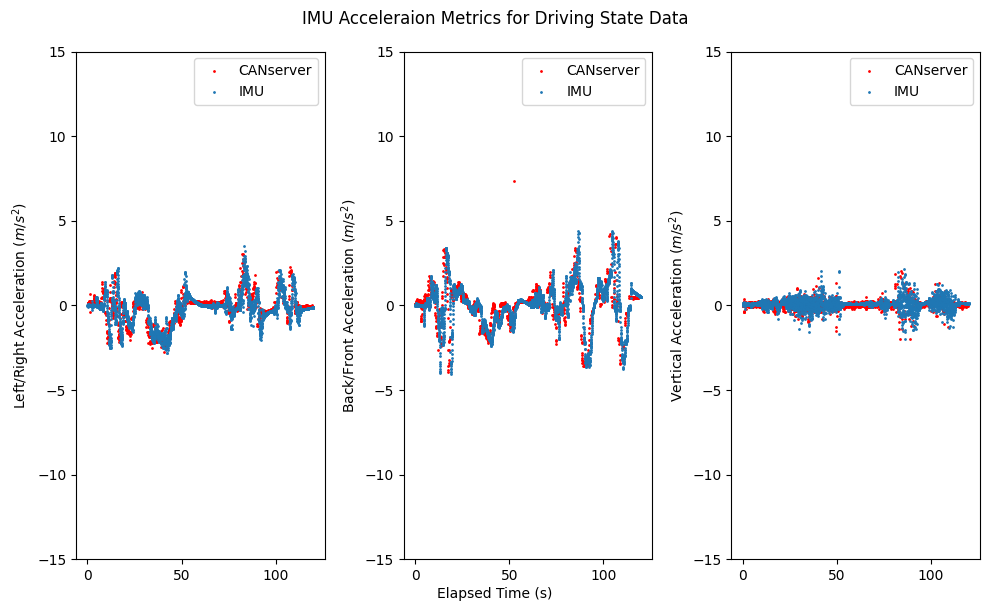

2


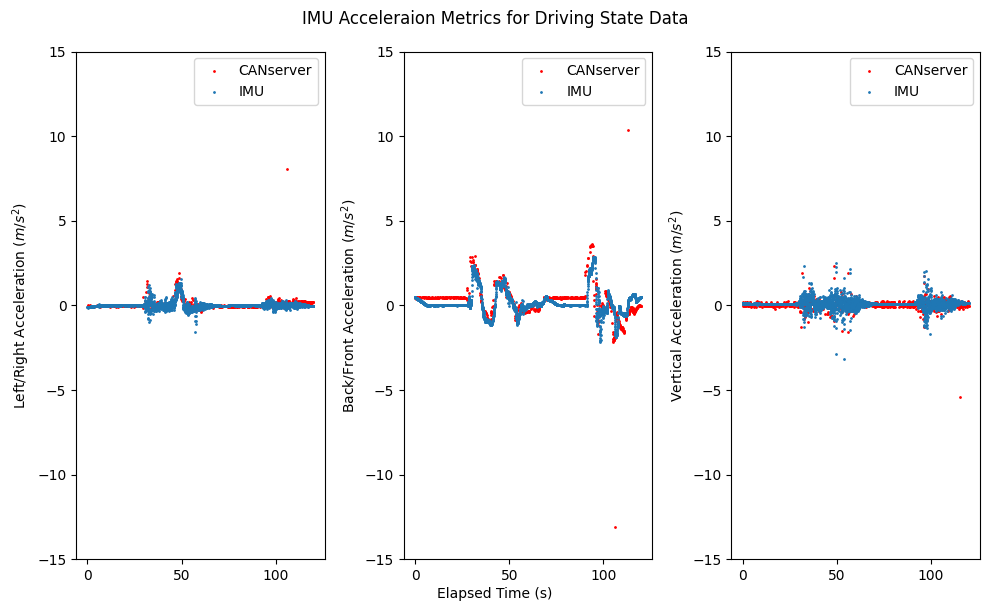

3


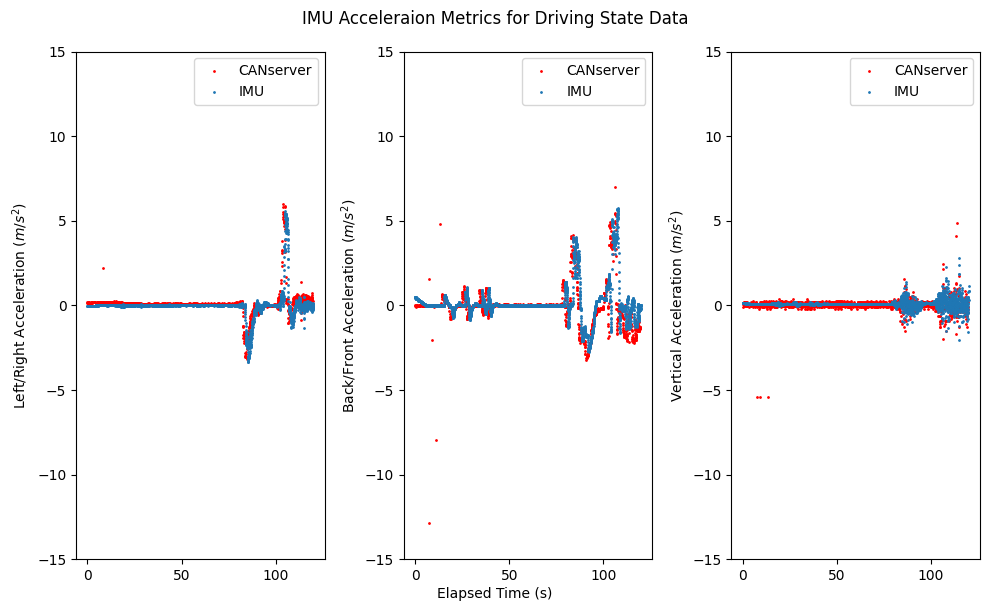

4


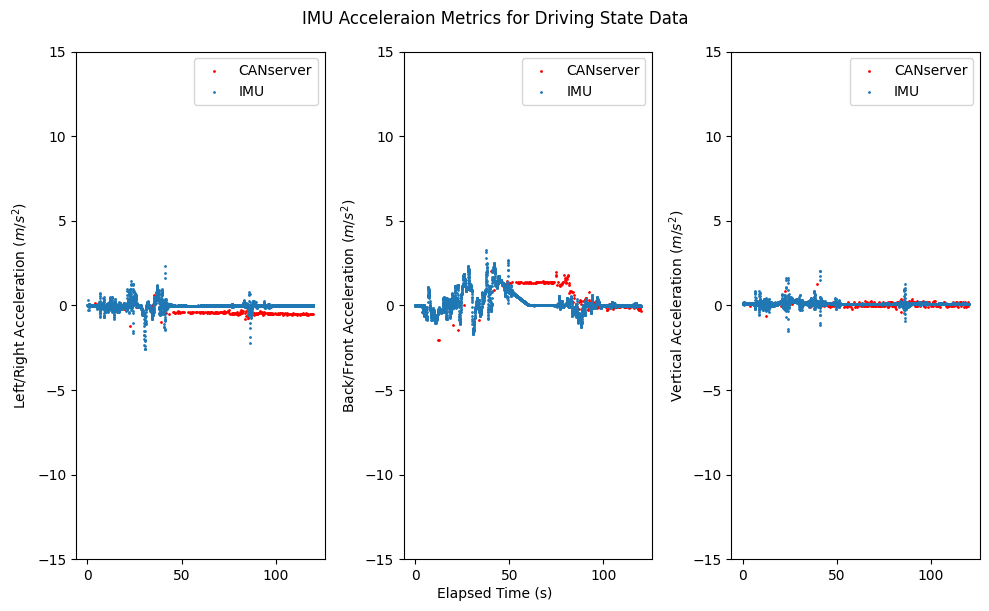

5


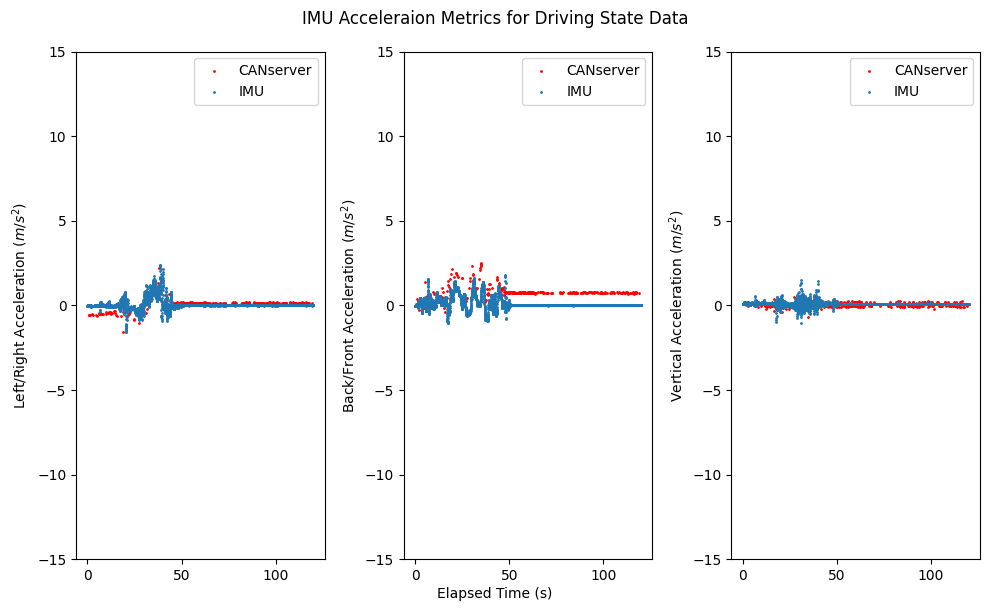

6


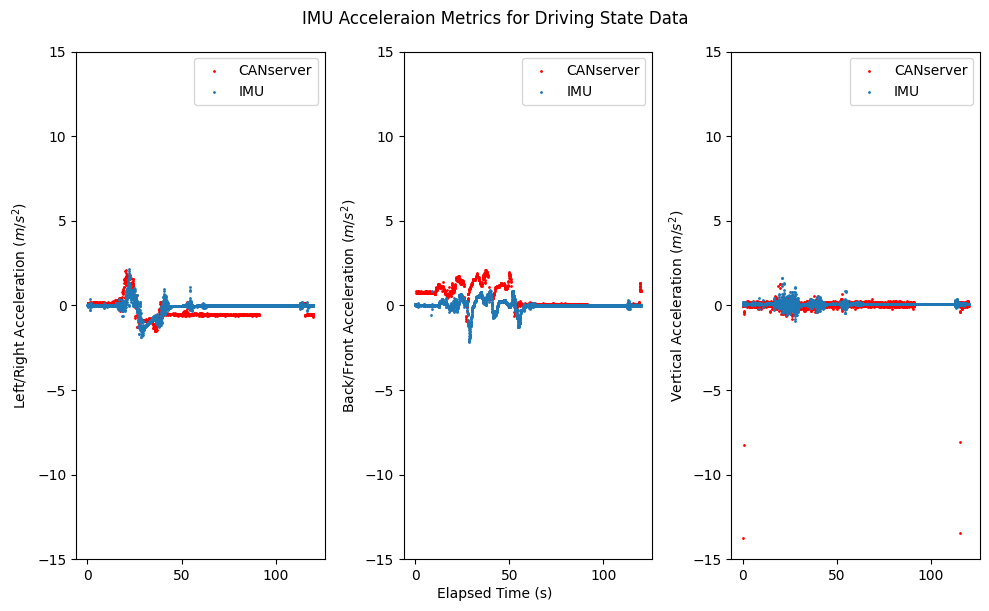

7


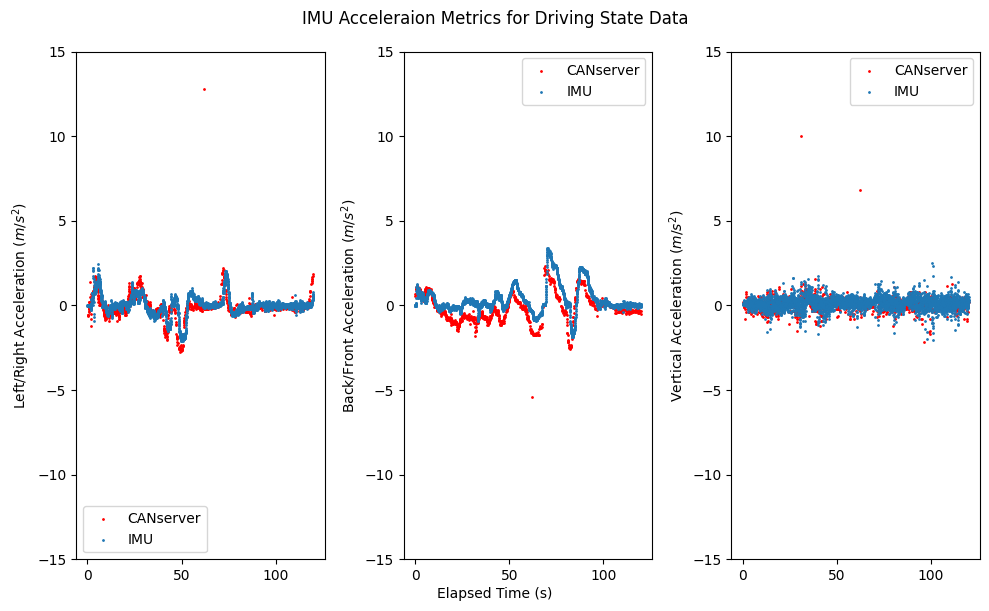

8


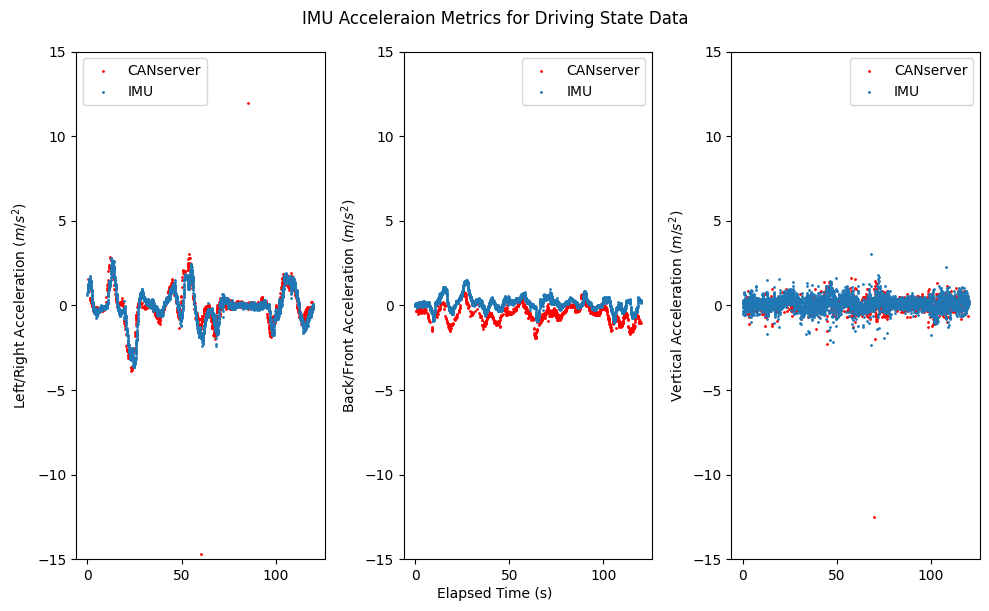

9


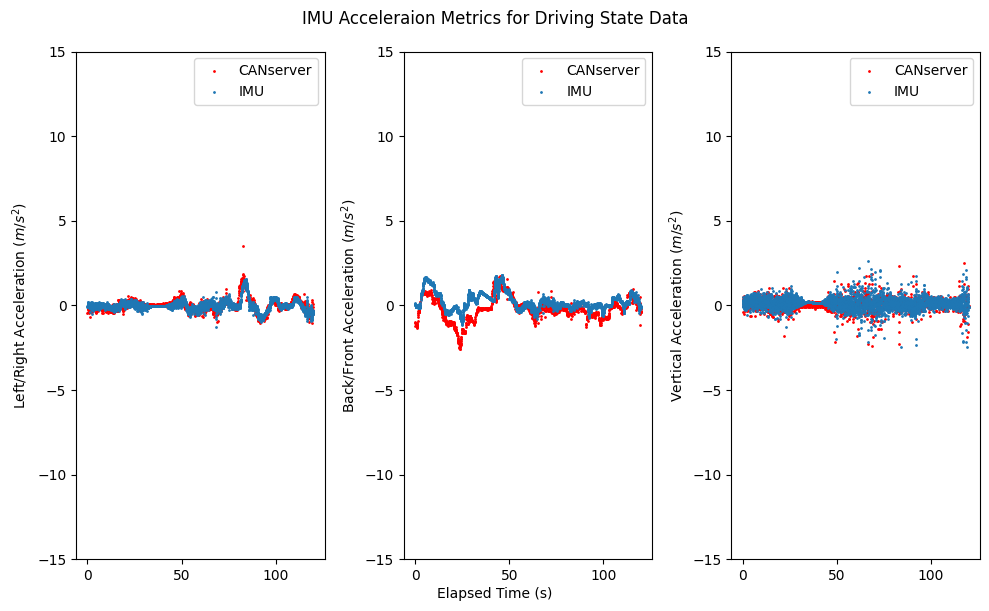

10


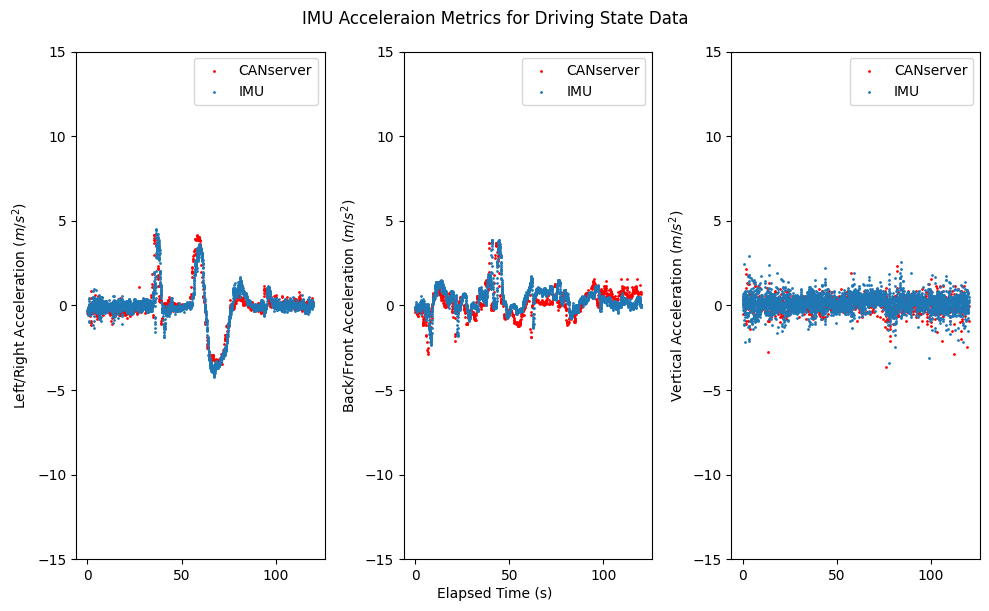

In [76]:
# plot driving state data in intervals of 120 seconds

window = 120
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = raw_df[(raw_df['correct_timestamp'] >= dr_start_time) 
                        & (raw_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
            count += 1
            print(count)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            lr_mean = dr_motion['lr_acc(m/s^2)'].mean()
            bf_mean = dr_motion['bf_acc(m/s^2)'].mean()
            vert_mean = dr_motion['vert_acc(m/s^2)'].mean()
            lr_can_mean = can_motion['lr_acc'].mean()
            bf_can_mean = can_motion['bf_acc'].mean()
            vert_can_mean = can_motion['vert_acc'].mean()

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()

Data Plotting for Verification

1


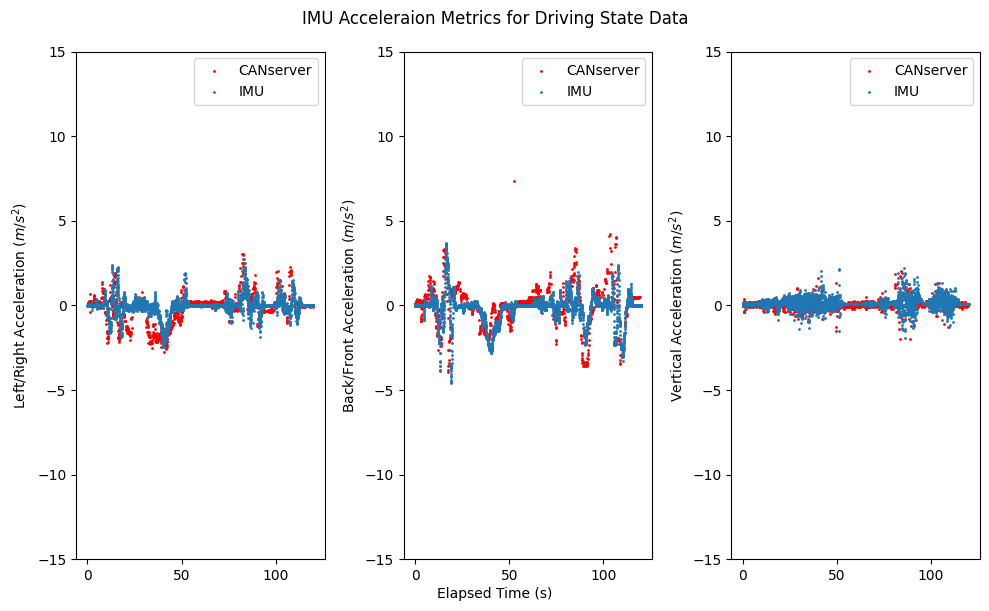

2


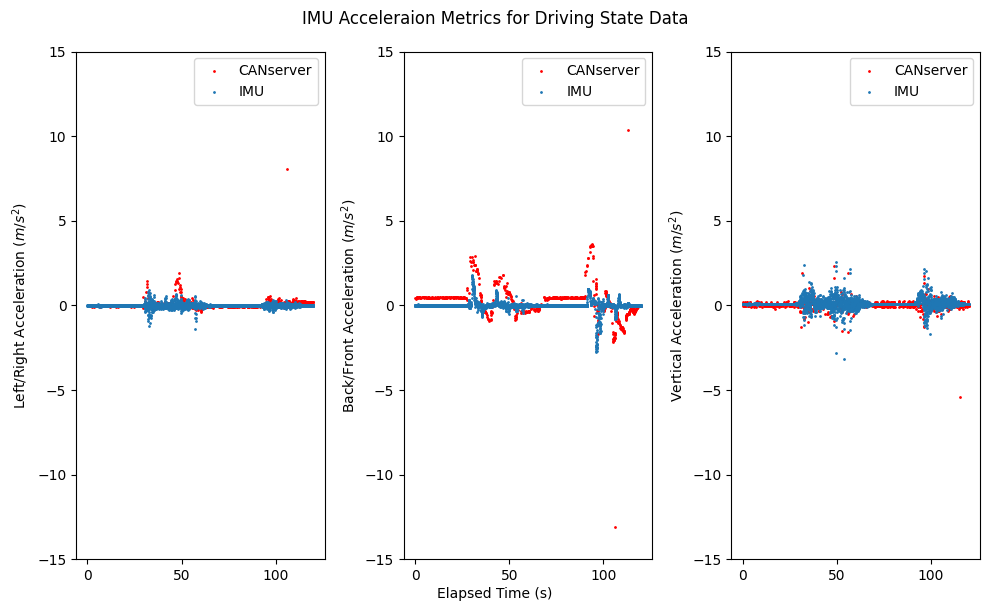

3


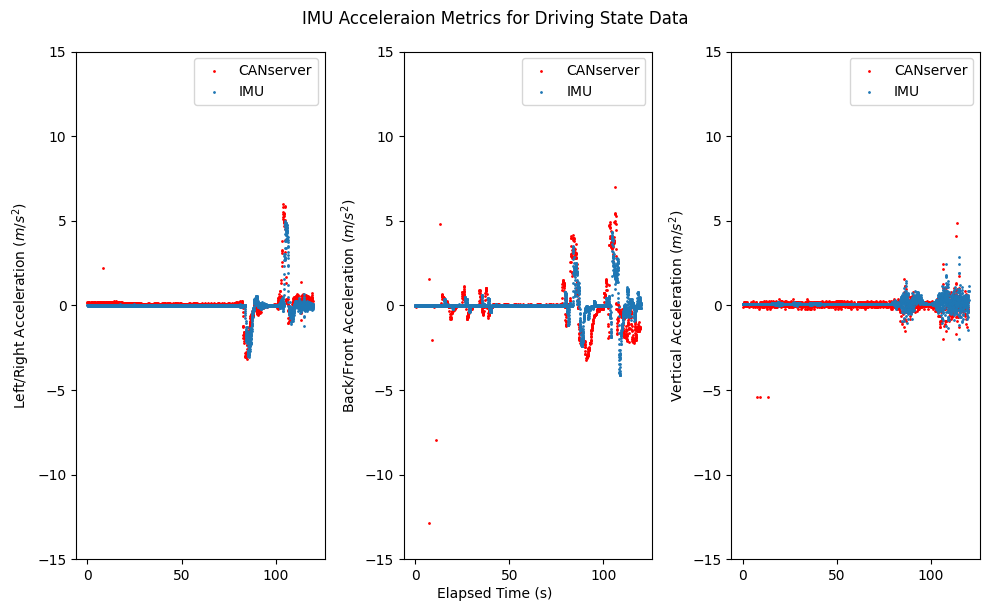

4


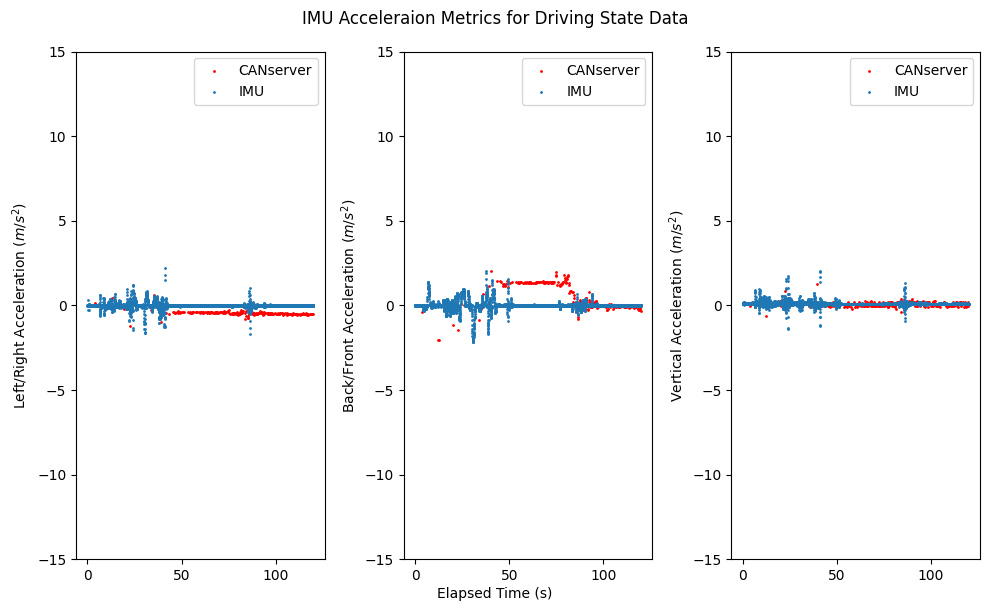

5


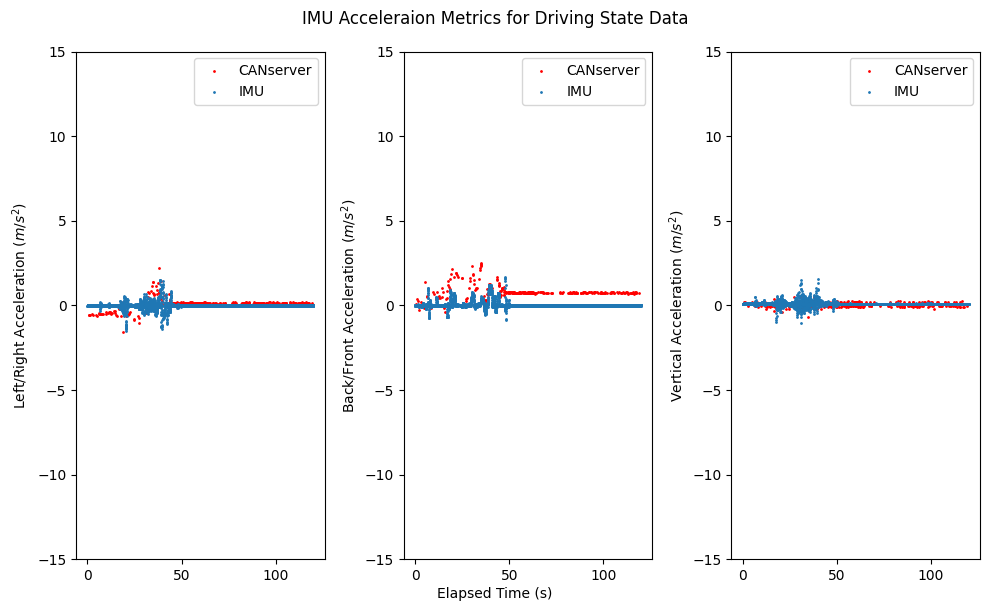

6


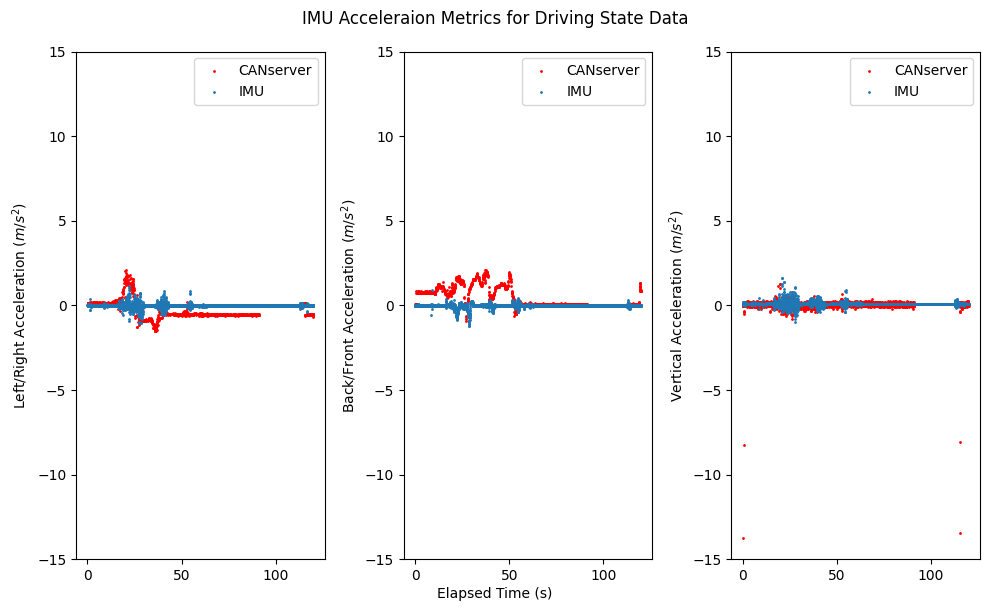

7


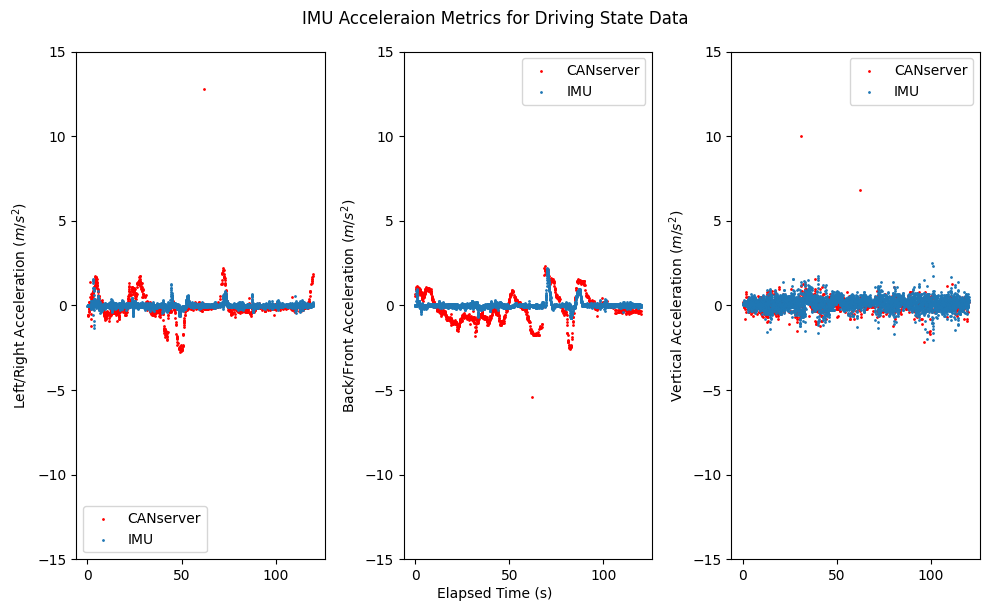

8


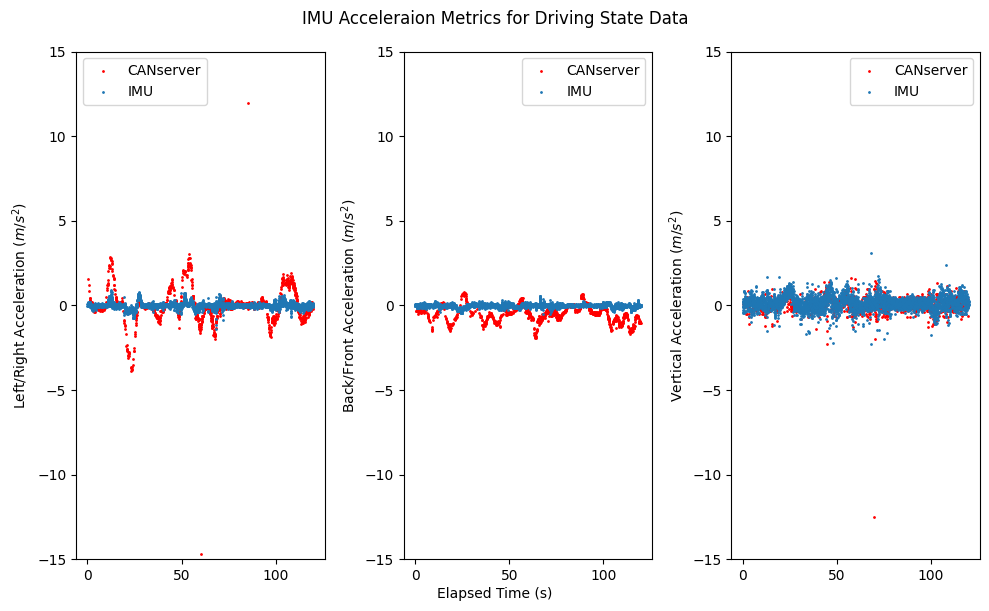

9


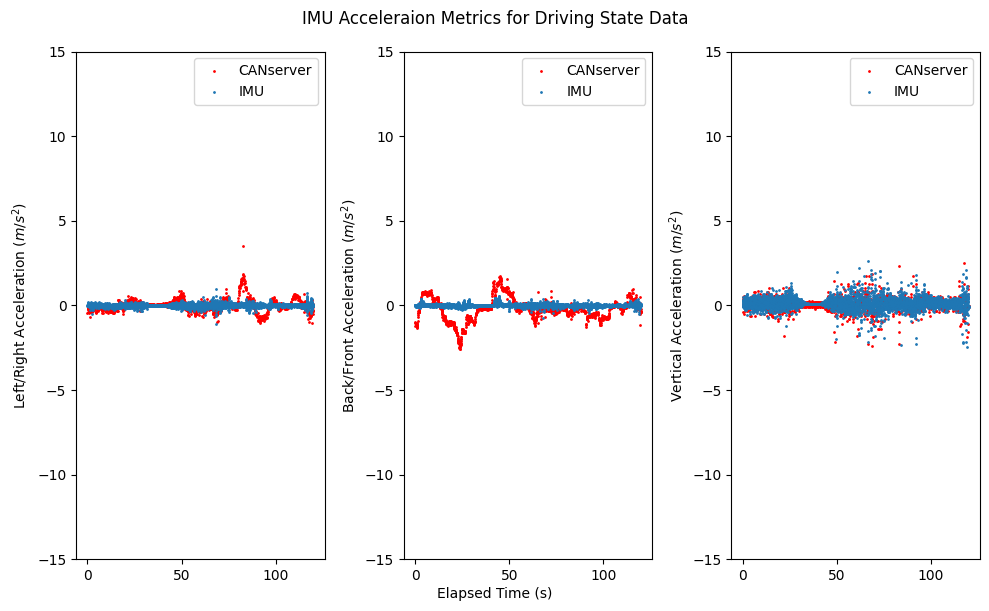

10


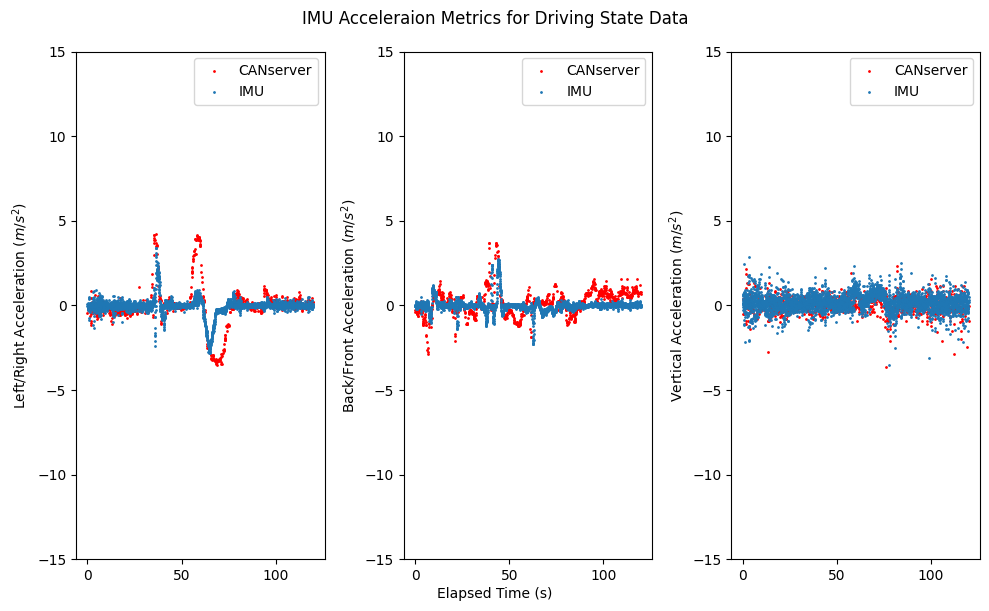

11


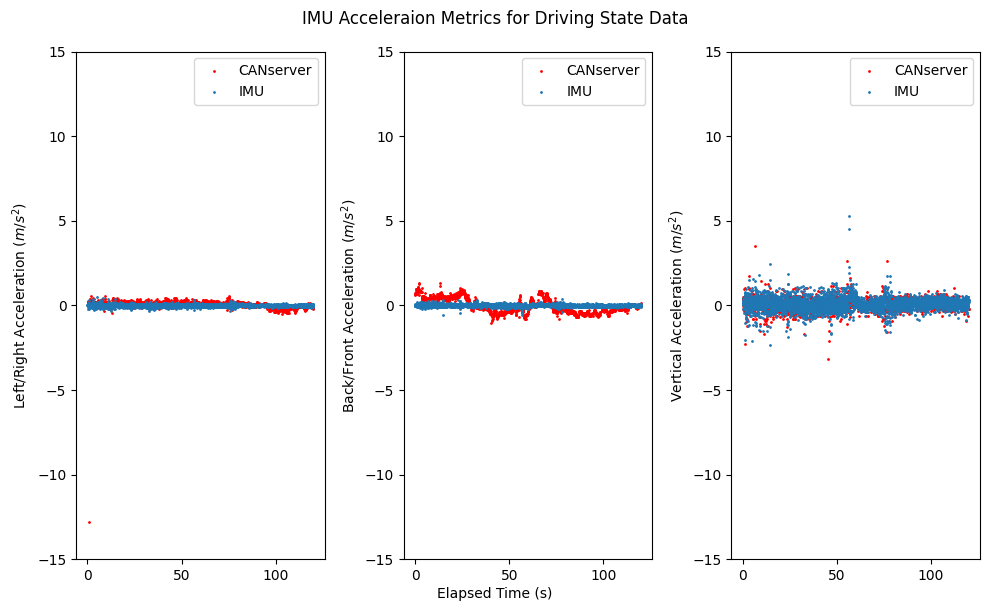

12


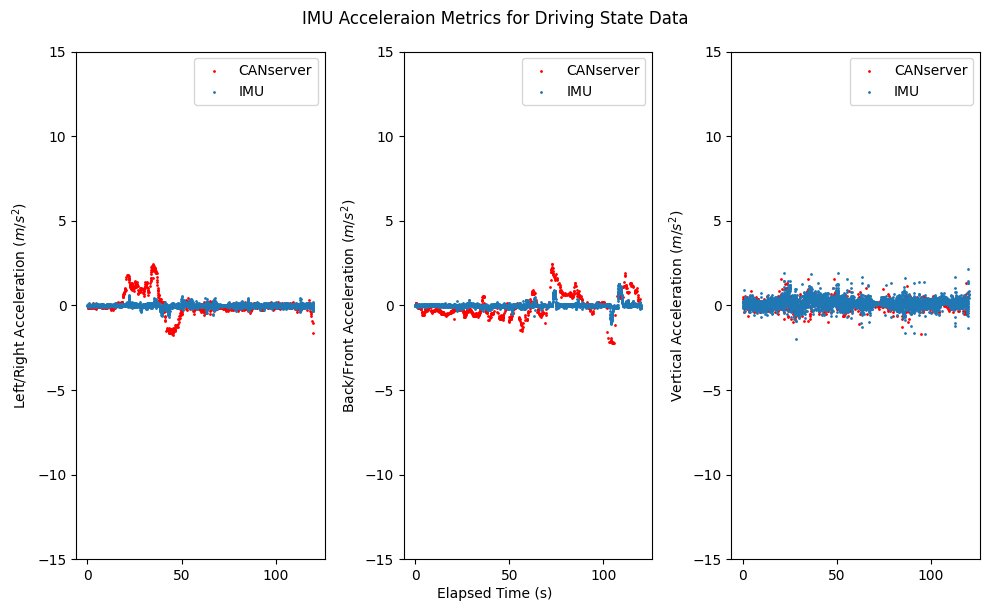

13


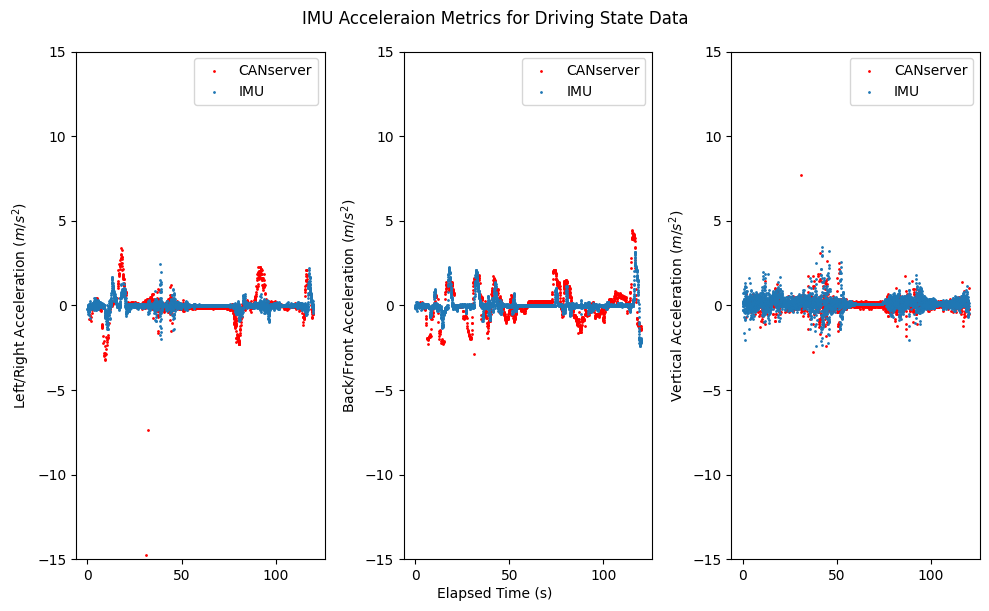

14


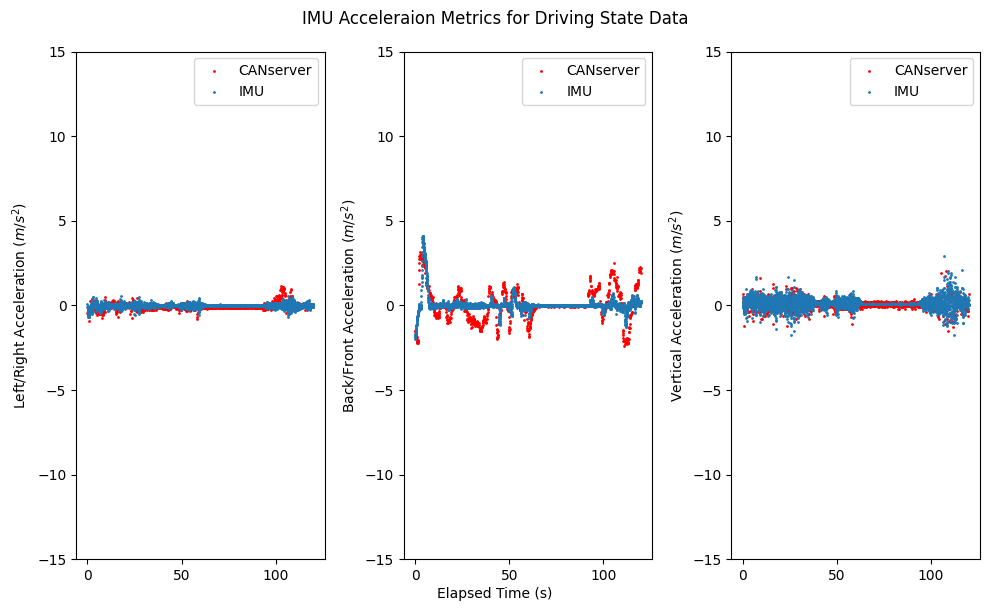

15


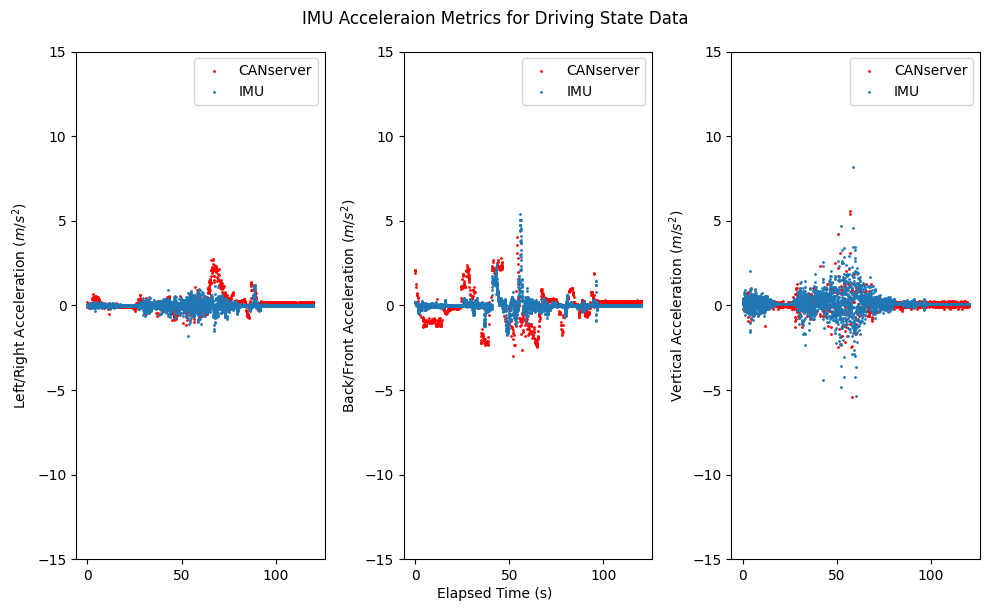

16


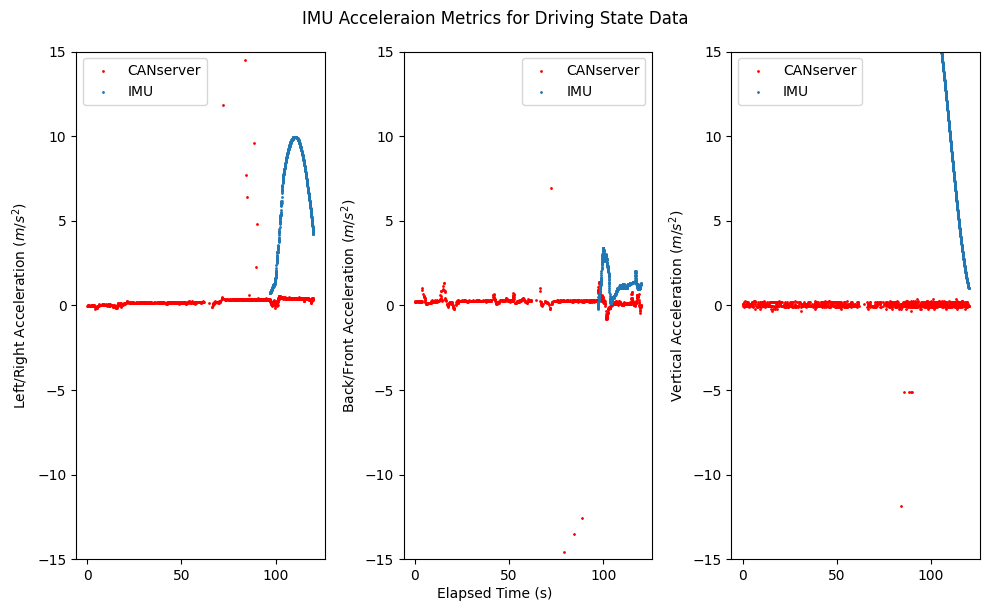

17


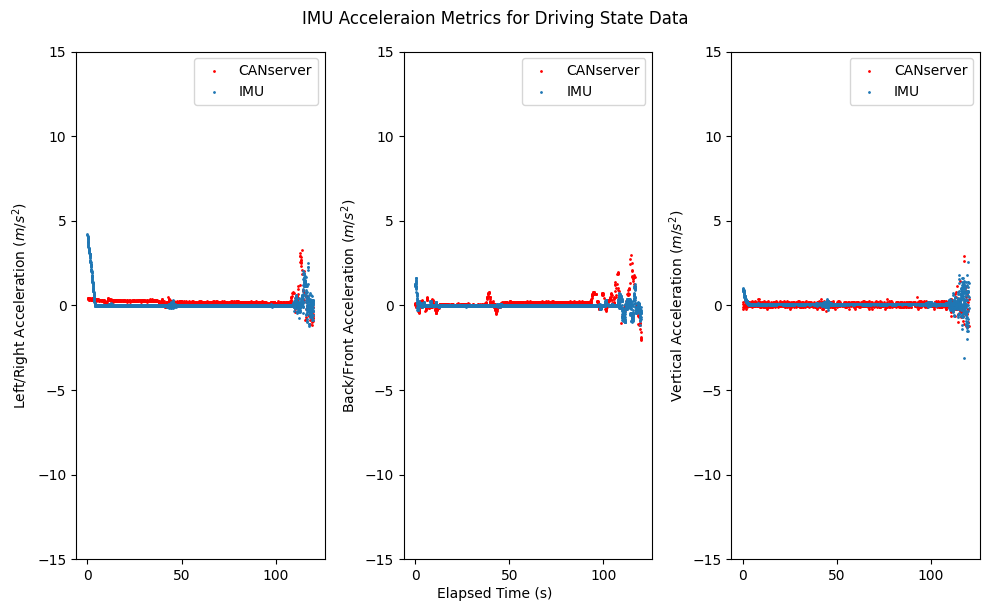

18


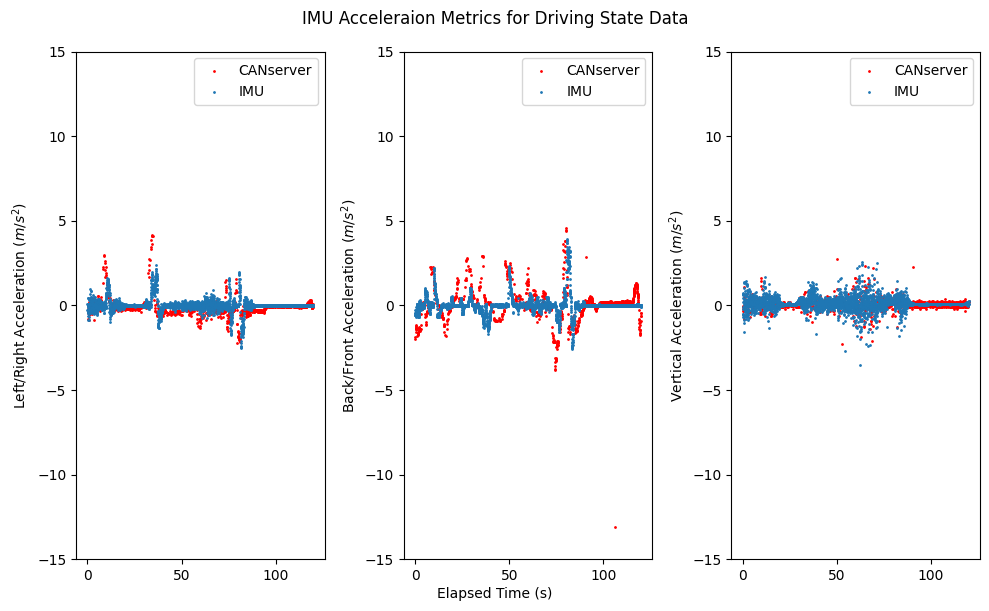

19


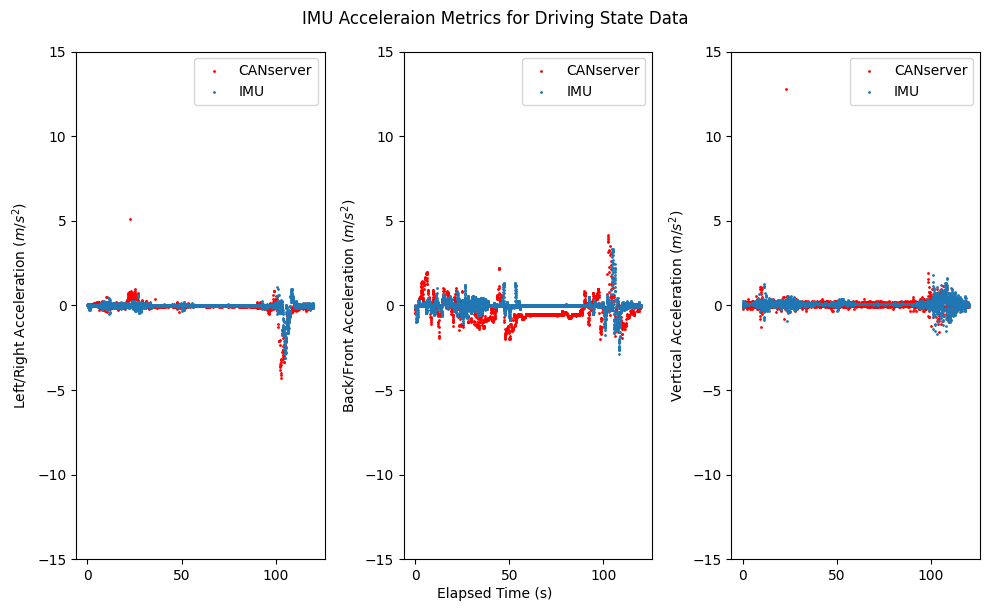

20


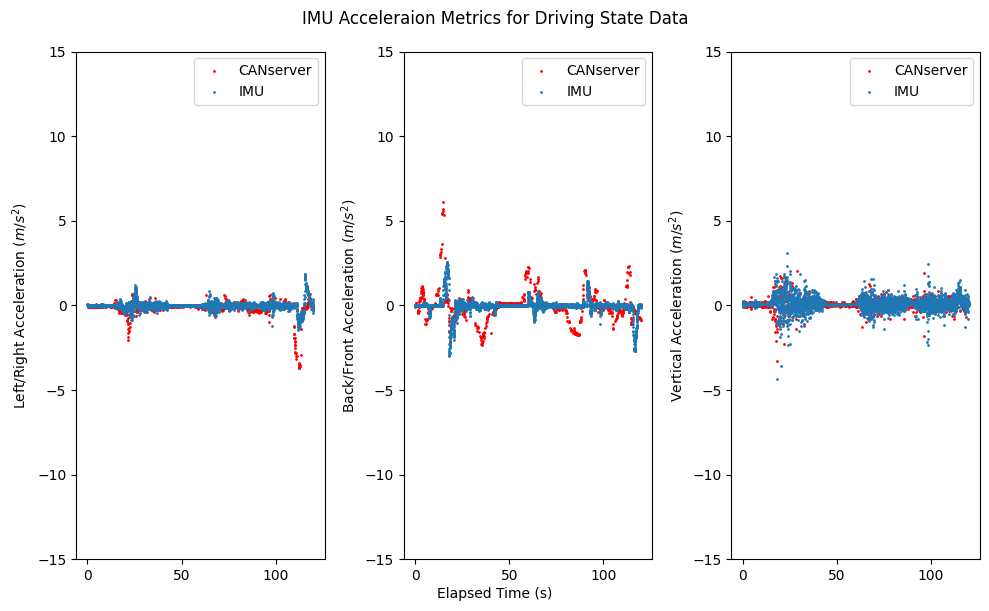

In [9]:
# plot driving state data in intervals of 120 seconds

window = 120
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = raw_df[(raw_df['correct_timestamp'] >= dr_start_time) 
                        & (raw_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
            count += 1
            print(count)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            lr_mean = dr_motion['lr_acc(m/s^2)'].mean()
            bf_mean = dr_motion['bf_acc(m/s^2)'].mean()
            vert_mean = dr_motion['vert_acc(m/s^2)'].mean()
            lr_can_mean = can_motion['lr_acc'].mean()
            bf_can_mean = can_motion['bf_acc'].mean()
            vert_can_mean = can_motion['vert_acc'].mean()

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()